# Prédiction du résultat d'une partie d'échecs en fonction de l'évaluation de l'ordinateur (stockfish)

**But :** Le but de ce projet est d'utiliser le machine learning pour prédire le résultat d'une partie d'échecs.

**Données :** On utilise une base de données SQL qui comprend 2000 parties jouées sur lichess et analysées par l'ordinateur. Chaque position de chaque partie a été analysée par stockfish (moteur d'analyse). La métrique utilisée par stockfish pour analyser une partie est le **centipion**, 100 centipions correspondent à la valeur d'un pion (ie. un avantage de 100 centipions (+1) correspond à un avantage d'un pion). 

**Méthode :** Après avoir chargé les données, on utilisera la regression logistique de scikit-learn pour prédire le résultat de la partie en se basant sur différentes features comme par exemple l'évaluation de la position par stockfish et la différence de niveau entre les 2 joueurs.

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


## Chargement des données.
Les données se trouvent dans une base SQL, on sélectionne les données qu'on va étudier à l'aide d'une requête SQL.


In [44]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


query1 = """
    SELECT
        g.result,
        --g.start_time + 40 * g.increment as total_time,
        g.increment,
        g.start_time,
        g.url,
        p.eval,
        p.ply,
        g.elo_white - g.elo_black as elo_dif,
        1 as weight
    FROM
        games g INNER JOIN positions p
        ON g.rowid = p.game_id
    WHERE
        g.result != 0
        AND p.eval is not NULL
    """

with sqlite3.connect("games.sqlite") as con:
    con.row_factory = dict_factory
    res = con.execute(query1)
    data = pd.DataFrame(res)

con.close()

In [45]:
data

,result,increment,start_time,url,eval,ply,elo_dif,weight
0,1,0,180,https://lichess.org/v17R9eiI,26.0,1,112,1
1,1,0,180,https://lichess.org/v17R9eiI,39.0,2,112,1
2,1,0,180,https://lichess.org/v17R9eiI,26.0,3,112,1
3,1,0,180,https://lichess.org/v17R9eiI,36.0,4,112,1
4,1,0,180,https://lichess.org/v17R9eiI,16.0,5,112,1
...,...,...,...,...,...,...,...,...
97925,1,0,180,https://lichess.org/obvNa1s6,0.0,41,-6,1
97926,1,0,180,https://lichess.org/obvNa1s6,0.0,42,-6,1
97927,1,0,180,https://lichess.org/obvNa1s6,0.0,43,-6,1
97928,1,0,180,https://lichess.org/obvNa1s6,966.0,44,-6,1


Chaque ligne correspond à une position d'une partie. Un "ply" correspond à un demi-coup. On va donc pondérer les données par le nombre de "ply" de la partie en question, de sorte que chaque partie ait le même poids dans le modèle final. On va également supprimer les positions correspondant à l'ouverture, c'est à dire avant le ply 20 (10ème coup). En effet l'évaluation de l'ouverture tend vers l'égalité et n'a en général pas d'impact sur le résultat final de la partie.

In [46]:
g = data.groupby("url").count()
data2 = data.merge(g.result, on="url", suffixes=("", "_y"))
data2.weight = data2.weight / data2.result_y

In [49]:
data2.head(10)

,result,increment,start_time,url,eval,ply,elo_dif,weight,result_y
0,1,0,180,https://lichess.org/v17R9eiI,26.0,1,112,0.009174,109
1,1,0,180,https://lichess.org/v17R9eiI,39.0,2,112,0.009174,109
2,1,0,180,https://lichess.org/v17R9eiI,26.0,3,112,0.009174,109
3,1,0,180,https://lichess.org/v17R9eiI,36.0,4,112,0.009174,109
4,1,0,180,https://lichess.org/v17R9eiI,16.0,5,112,0.009174,109
5,1,0,180,https://lichess.org/v17R9eiI,32.0,6,112,0.009174,109
6,1,0,180,https://lichess.org/v17R9eiI,19.0,7,112,0.009174,109
7,1,0,180,https://lichess.org/v17R9eiI,24.0,8,112,0.009174,109
8,1,0,180,https://lichess.org/v17R9eiI,25.0,9,112,0.009174,109
9,1,0,180,https://lichess.org/v17R9eiI,40.0,10,112,0.009174,109


In [51]:
data3 = data2[data2["ply"]>20]

## Modèle de machine learning avec scikit-learn
Pour prédire le résultat de la partie, on va garder les 2 features les plus importantes, à savoir l'évaluation de la position et la différence de niveau entre les 2 joueurs, on va ensuite standardiser nos données à l'aide de ``StandardScaler`` puis on va effectuer la régression logistique de scikit-learn : ``LogisticRegressionCV`` qui utilise la cross-validation pour trouver les meilleurs hyperparamètres. On utilisera une régularisation de 1.

In [53]:
random_state = 42

features = [
    "eval",
    # "ply",
    "elo_dif",
    # "start_time",
    # "increment",
    # "total_time"
]

X = data3[features]
y = data3.result
weights = data3.weight

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=random_state, stratify=y
)

scaler = StandardScaler(
    with_mean=False,
)

classifier = LogisticRegressionCV(
    max_iter=200,
    # Cs=15,
    Cs=[1],
    random_state=random_state,
    n_jobs=-1,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=np.linspace(0, 1, num=10),
    # fit_intercept=False,
    # class_weight="balanced",
)


model = Pipeline(
    steps=[
        ("scaler", scaler),
        ("classifier", classifier),
    ]
)

model.fit(
    X_train,
    y_train,
    scaler__sample_weight=weights_train,
    # classifier__sample_weight=weights_train,
)

Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('classifier',
                 LogisticRegressionCV(Cs=[1],
                                      l1_ratios=array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                      max_iter=200, n_jobs=-1,
                                      penalty='elasticnet', random_state=42,
                                      solver='saga'))])

## Résultats
On obtient un score de 0.77, c'est à dire que notre modèle prédit correctement le résultat dans 77% des cas, ce qui semble très convainquant.

In [57]:
model.score(X_test,y_test,sample_weight=weights_test)

0.777807949773873

In [55]:
print(f"Accuracy: \n {model.score(X_test, y_test, sample_weight=weights_test)}")
scale = model.named_steps["scaler"].scale_
mean = model.named_steps["scaler"].mean_
print(f"Mean: \n {mean}")

coefs = model.named_steps["classifier"].coef_ / scale
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["classifier"].intercept_
print(f"Intercept: \n {intercept}")

cs = model.named_steps["classifier"].C_
print(f"Regularization strenght: \n {cs}")

l1_ratio = model.named_steps["classifier"].l1_ratio_
print(f"L1 Ratio: {l1_ratio}")

Accuracy: 
 0.777807949773873
Mean: 
 [41.38282982 -3.80362786]
Coefficients: 
 [[0.00290338 0.0062302 ]]
Intercept: 
 [-0.05852703]
Regularization strenght: 
 [1]
L1 Ratio: [0.66666667]


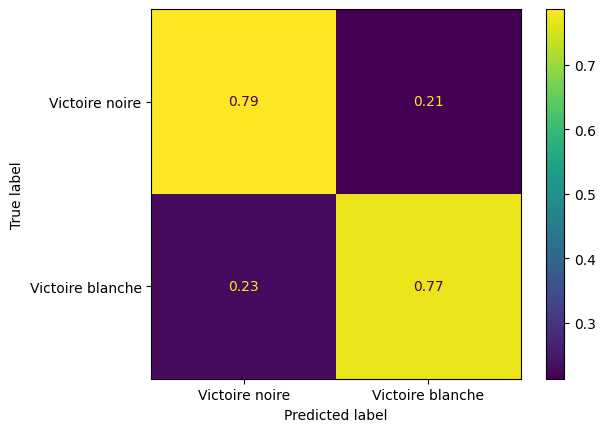

In [56]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    sample_weight=weights_test,
    normalize="true",
    display_labels=[
        "Victoire noire",
        # "Partie nulle",
        "Victoire blanche",
    ],
)


Notre modèle arrive à prévoir un peu mieux la victoire noire que la victoire blanche.

C:\Users\danih\AppData\Local\Temp\ipykernel_13384\3123961270.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_plot.loc[:, "result"] = (data_plot.loc[:, "result"] + 1).copy() / 2


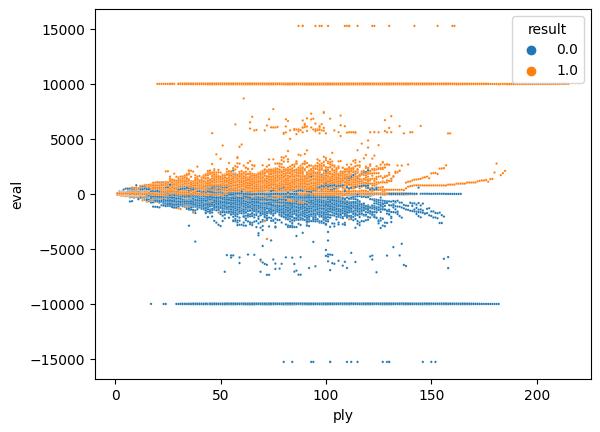

In [62]:
pd.set_option("mode.chained_assignment", None)

data_plot = data[["eval", "ply", "elo_dif", "result", "increment"]]
data_plot.loc[:, "result"] = (data_plot.loc[:, "result"] + 1).copy() / 2

g = sns.scatterplot(
    data_plot,
    x="ply",
    y="eval",
    hue="result",
    s=3,
    # palette="viridis",
)
legend = ["Victoire noire", "Nulle", "Victoire blanche",]


On observe que plus l'évaluation est grande, plus le résultat est certain. L'évaluation est plus décisive en fin de partie qu'au début (ouverture).

[Text(0.5, 1.0, "% de gain en fonction de l'évaluation de l'ordi")]

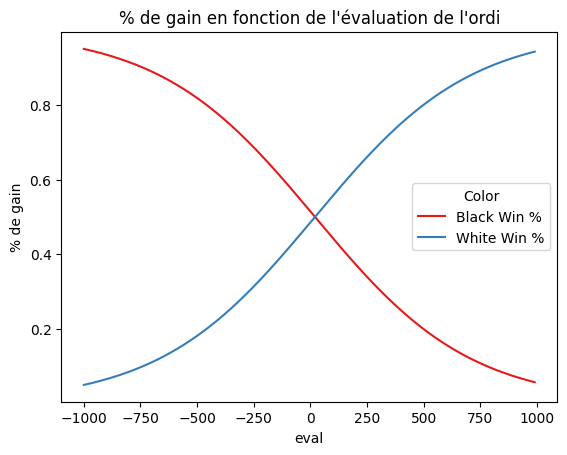

In [81]:
d = {'eval' : np.arange(-1000, 1000, 10), 'elo_dif' : np.zeros(200)}
cps = pd.DataFrame(data = d, columns=["eval", "elo_dif"])
pred = pd.DataFrame(
    model.predict_proba(cps),
    columns=[
        "Black Win %",
        # "Draw %",
        "White Win %",
    ],
)
data_plot = pd.concat([cps["eval"], pred], axis=1)

df_melted = data_plot.melt("eval", var_name="Color", value_name="% de gain")

sns.lineplot(data=df_melted, x="eval", y="% de gain", hue="Color", palette="Set1").set(title = "% de gain en fonction de l'évaluation de l'ordi")
